# Music Generation with LSTM

### Amaç: Ön işlemesini yaptığım piyano verilerini verdiğim ve **lstm** katmanı içeren modelimin, yeni bir audio file üretebilmesi

#### Adımlar:
1. Importing Libs
2. Uploading Train Data
3. Analyzing Data
4. Data Preprocessing
5. Building Model
6. Evaluating Model
7. Outcomes

## 1. IMPORTING LIBS

Modelimizi tensorflow yardımı ile oluşturacağız. Music dosyalarımız için ise *music21* paketimizden yararlanacağız.

In [1]:
import tensorflow 
import os
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

## 2. UPLOADING TRAIN DATA

MIDI dosyaları bize sanatçıların şarkılar için yazdığı akorları ve melodileri sunan *.mid* uzantılı ses dosyalarıdır. <br> 
Bu kısımda ana dosyamda bulunan beethovena ait 9 farklı şarkımı upload ediyorum. <br> 
Bu döngü sayesinde uzantısı sadece .mid ile biten dosyaları çekiyorum ve *all_midis* ismini verdiğim bir listede tutuyorum. <br> 
Sonrasında örneğin dosyamın ismi Beethoven1.mid ise
Bu dosyayı kabul et, tr diye bir geçici değişkende ele alacak olduğum şarkının asıl pathini yani BeethovenMidiFiles/Beethoven1.mid'i tut, <br> 
sonra midi diye başka bir değişkende music21 paketinden gelen converter.parse ike music dosyasını tutuyoruz,<br> 
en sonda all_midis diye oluşturduğumuz boş arraye bunları append ediyoruz yani birleştiyoruz 
loop son buluyor...


In [3]:
filepath = "BeethovenMidiFiles/"

all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

## 3. ANALYZING DATA

Midi dosyaları notaları ve akorları beraber tutarlar. <br>
Notalar bildiğimiz üzer A B C D E G  şeklinde 
do re mi fa ... ya tekabül etmektedir <br> ve farklı perdeleri vs vs (çok bilmiyorum) ifade etmek üzere G# gibi ya da A2 gibi
ifadeler ile tutulmaktadır. <br>Akorlar ise birden fazla notaları içeren ses kümeleri dir diyebiliriz.<br>
Biz yalnızca notalar üzerinde işlem yapacağımız için all_midis arrayimizde bulunan her bir şarkı için
notaları extract etmemiz gerekmektedir.<br>
Bunu da aşağıdaki fonksiyon aracığı ile yaptık. <br>Ve bu extract edilen notaları Corpus isimli bir değişkende tuttuk<br>


In [4]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

Artık ilgilenecek olduğumuz veriler corpus isimli değişkende tutulmaktadır. <br>
Bu notaları inceleyeceğiz ve üzerilerinde işlem yapacağız.

In [6]:
Corpus= extract_notes(all_midis)
print("Total notes in all the Beethoven midis in the dataset:", len(Corpus))
print("First fifty values in the Corpus:", Corpus[:50])

Total notes in all the Chopin midis in the dataset: 39325
First fifty values in the Corpus: ['7.11', '9.0', '11.2', 'G2', '10.1', '11.2', 'B2', '10.1', '11.2', 'D3', '10.1', '11.2', 'G3', 'G2', '0.4', '8.11', '9.0', 'D3', 'D2', '11.2', '6.9', '7', 'B4', 'G1', '7.11', '9.2', '7.11', 'G2', '6.10', '7.11', 'B2', '6.10', '7.11', 'E-3', '6.10', '7.11', 'E3', 'F#3', '6.9', 'G3', '4.7', '4.7', 'A3', '2.6', '2.6', 'A2', '6.9', '4.7', '1.4', '2']


şunu print ederek ilk elli notamızı inceleyim. hangi notalar varmış elimizde?? <br>
   toplamda 39325 tane notamız var buarada<br>
   bütün bu sözel şekilde ifade edilen notalar müzikçilerin anlayacağı dildeki notalara python ile çevilebilir
yani biz bu notaları nota portresinde gösterebiliriz. bunun için şu kodu yazıyoruz.


In [10]:
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 293


## 4. DATA PREPROCESSING
"En çok ve en az bulunan notaları yazdırıyoruz. <br>
Çünkü bazı notalar sıklıkla gözükürken bazıları çok az gözükmektedir<br>
ve çok az gözüken notalar yeni generate edeceğimiz fileın yapısını bozabilir.<br>
İlerleyen fonksiyonumuzda bu az gözüken notaları liste dışında bırakacağız. Ve sıklıkla
gözüken notalara odaklanacağız."<br>

In [11]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")


Average recurrenc for a note in Corpus: 134.21501706484642
Most frequent note in Corpus appeared: 1189 times
Least frequent note in Corpus appeared: 1 time


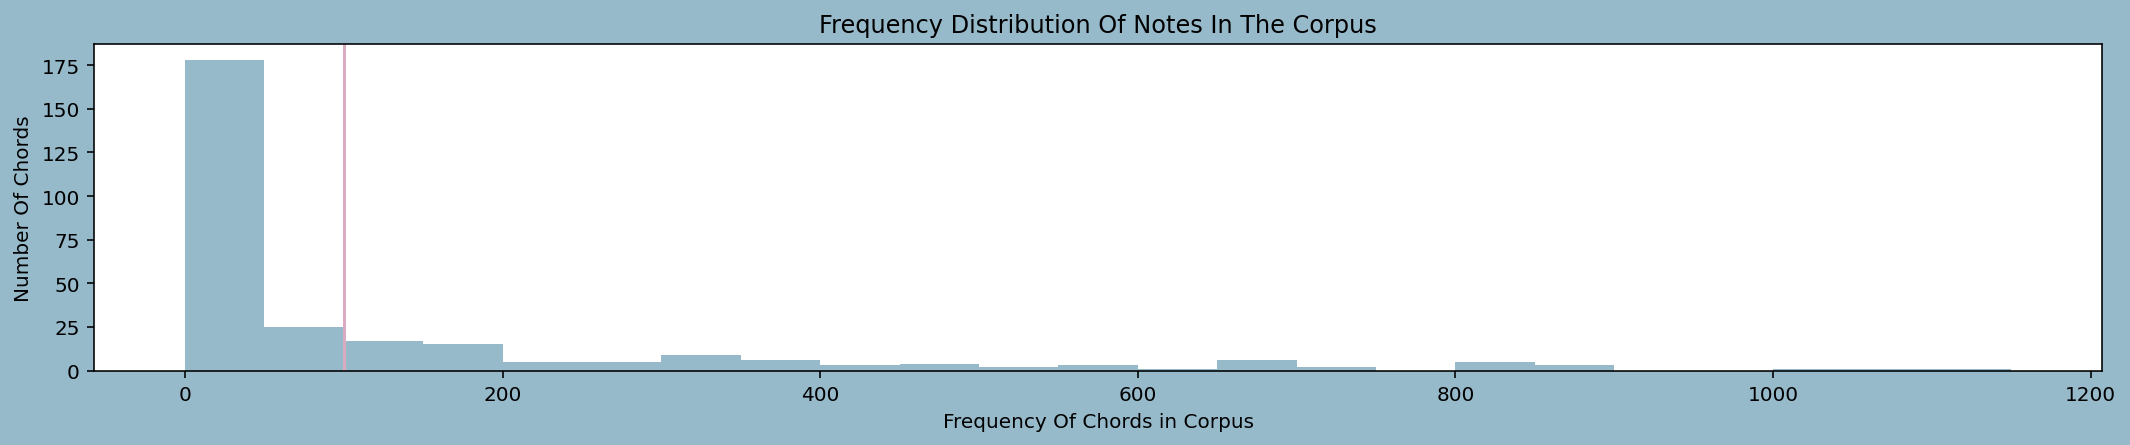

In [12]:
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

Görülme sıklığı az olan akorlarımızı biz listede turuyoruz ki sonra bunları eleyelim.

In [14]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 203


Görülme sıklığı az olan notaları devre dışı bırakıyoruz.
remove() fonksiyonumuz bu notaları rare_note ismini verdiğimiz listeden temizliyor.

In [15]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 36395


In [16]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 36395
Number of unique characters: 243


In [17]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 36355


In [18]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. BUILDING MODEL

In [20]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 243)               62451     
                                                                 
Total params: 1,968,371
Trainable params: 1,968,371
No

Training model

In [21]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
  1/114 [..............................] - ETA: 8:40 - loss: 5.4932

KeyboardInterrupt: 

In [ ]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")


def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)


#To save the generated melody
Melody.write('midi','C/../Melody_Generated.mid')
#to play audio or corpus
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated 2.wav")

